# Import Libraries

In [1]:
import pandas as pd
 

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import CategoricalNB, GaussianNB

from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from datetime import datetime
from tqdm import tqdm
import yaml
import joblib
import json
import copy
import hashlib

# Load the Datasets

In [2]:
pkl_folder = "/root/ml_process_feb23/data/processed/"

df_train = joblib.load(pkl_folder + "df_train.pkl")
x_train = df_train.drop(['card'], axis = 1)
y_train = df_train['card']

df_train_rus = joblib.load(pkl_folder + "df_train_rus.pkl")
x_train_rus = df_train_rus.drop(['card'], axis = 1)
y_train_rus = df_train_rus['card']

df_train_ros = joblib.load(pkl_folder + "df_train_ros.pkl")
x_train_ros = df_train_ros.drop(['card'], axis = 1)
y_train_ros = df_train_ros['card']

df_train_smote = joblib.load(pkl_folder + "df_train_smote.pkl")
x_train_smote = df_train_smote.drop(['card'], axis = 1)
y_train_smote = df_train_smote['card']

df_valid = joblib.load(pkl_folder + "df_valid.pkl")
x_valid = df_valid.drop(['card'], axis = 1)
y_valid = df_valid['card']

df_test = joblib.load(pkl_folder + "df_test.pkl")
x_test = df_test.drop(['card'], axis = 1)
y_test = df_test['card']

## Selecting features to be trained

In [3]:
x_test.columns.values

array(['index', 'reports', 'age', 'share', 'owner', 'selfemp',
       'dependents', 'majorcards', 'active', 'income_log',
       'expenditure_log', 'months_log', 'age_bin', 'reports_bin',
       'dependents_bin', 'active_bin'], dtype=object)

In [4]:
# Create instances for some binned features and its original value
bins = ['age_bin', 'reports_bin', 'dependents_bin', 'active_bin']
ori_value = ['age', 'reports', 'dependents', 'active']

For the **baseline model**, I will not include the binned features.

In [5]:
# Create the independent variables for baseline model
x_train_base = x_train.drop(bins, axis = 1)
x_train_rus_base = x_train_rus.drop(bins, axis = 1)
x_train_ros_base = x_train_ros.drop(bins, axis = 1)
x_train_smote_base = x_train_smote.drop(bins, axis = 1)
x_valid_base = x_valid.drop(bins, axis = 1)
x_test_base = x_test.drop(bins, axis = 1)


For the **alternative model**, I use the binned features.

In [6]:
# Create the independent variables for alternative model
x_train_bin = x_train.drop(ori_value, axis = 1)
x_train_rus_bin = x_train_rus.drop(ori_value, axis = 1)
x_train_ros_bin = x_train_ros.drop(ori_value, axis = 1)
x_train_smote_bin = x_train_smote.drop(ori_value, axis = 1)
x_valid_bin = x_valid.drop(ori_value, axis = 1)
x_test_bin = x_test.drop(ori_value, axis = 1)

# Create Log Template

In [7]:
def time_stamp():
    return datetime.now()

In [8]:
def create_log_template():
    logger = {
        "model_name" : [],
        "model_uid" : [],
        "training_time" : [],
        "training_date" : [],
        "performance" : [],
        "f1_score_avg" : [],
        "accuracy" :[],
        "data_configurations" : [],
    }

    return logger

In [9]:
def training_log_updater(current_log, log_path):
    current_log = current_log.copy()

    try:
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    except FileNotFoundError as ffe:
        with open(log_path, "w") as file:
            file.write("[]")
        file.close()
        with open(log_path, "r") as file:
            last_log = json.load(file)
        file.close()
    
    last_log.append(current_log)

    with open(log_path, "w") as file:
        json.dump(last_log, file)
        file.close()

    return last_log

# Training and Evaluation

## Create Model Object

Create instance for each algorithm function

In [10]:
lgr      = LogisticRegression(random_state = 12)      # Logistic regression
svm      = SVC(random_state = 23)                     # Support Vector Machine 
dct      = DecisionTreeClassifier(random_state = 34)  # Decision tree Classifier
rfc      = RandomForestClassifier(random_state = 45)  # Random Forest Classifier
knn      = KNeighborsClassifier()                     # k-Nearest Neighbors CLassifier
xgb      = XGBClassifier(random_state = 67)           # XG Boost Classifier
nb_cat   = CategoricalNB()                            # Categorical Naive Bayes Classifier
nb_gauss = GaussianNB()                               # Gaussian Naive Bayes Classifier

In [11]:
list_of_model = {
    "imbalanced" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "undersampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "oversampling" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    "smote" : [
        { "model_name": lgr.__class__.__name__, "model_object": lgr, "model_uid": ""},
        { "model_name": svm.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": dct.__class__.__name__, "model_object": dct, "model_uid": ""},
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": knn.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": nb_cat.__class__.__name__, "model_object": knn, "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": xgb, "model_uid": ""}
        ],
    }

In [12]:
def train_eval_model(list_of_model, prefix_model_name, x_train, y_train, data_configuration_name, x_valid, y_valid, log_path):

    list_of_model = copy.deepcopy(list_of_model)
    logger = create_log_template()

    for model in tqdm(list_of_model):    
        model_name = prefix_model_name + "-" + model["model_name"]

        start_time = time_stamp()
        model["model_object"].fit(x_train, y_train)
        finished_time = time_stamp()

        elapsed_time = finished_time - start_time
        elapsed_time = elapsed_time.total_seconds()

        y_pred = model["model_object"].predict(x_valid)
        performance = classification_report(y_valid, y_pred, output_dict = True)

        plain_id = str(start_time) + str(finished_time)
        chiper_id = hashlib.md5(plain_id.encode()).hexdigest()

        model["model_uid"] = chiper_id

        logger["model_name"].append(model_name)
        logger["model_uid"].append(chiper_id)
        logger["training_time"].append(elapsed_time)
        logger["training_date"].append(str(start_time))
        logger["performance"].append(performance)
        logger["f1_score_avg"].append(performance["macro avg"]["f1-score"])
        logger["accuracy"].append(performance["accuracy"])
        logger["data_configurations"].append(data_configuration_name)

    training_log = training_log_updater(logger, log_path)

    return training_log, list_of_model

In [13]:
def training_log_to_df(training_log):
    training_res = pd.DataFrame()

    for log in tqdm(training_log):
        training_res = pd.concat([training_res, pd.DataFrame(log)])
    
    training_res.sort_values(["accuracy", "training_time"], ascending = [False, True], inplace = True)
    training_res.reset_index(inplace = True, drop = True)
    
    return training_res

In [14]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["accuracy", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object
    

## Train and Evaluate the Baseline Models

### Original (imbalanced) data

In [15]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:04<00:00,  1.85it/s]


In [16]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

### Balanced with undersampling

In [17]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "baseline_model",
    x_train_rus_base,
    y_train_rus,
    "undersampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  7.59it/s]


In [18]:
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)

### Balanced with oversampling

In [19]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "baseline_model",
    x_train_ros_base,
    y_train_ros,
    "oversampling",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.64it/s]


In [20]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

### Balanced with SMOTE

In [21]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_smote_base,
    y_train_smote,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_baseline.json"
)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:05<00:00,  1.45it/s]


In [22]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.

In [23]:
training_res_baseline = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00,  8.55it/s]


In [24]:
training_res_baseline

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,baseline_model-RandomForestClassifier,624be8210dbf273b37d87500a5216eb1,0.651896,2023-03-27 10:45:32.885928,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
1,baseline_model-GaussianNB,619727e050631e96a1382a135b70401e,0.160795,2023-03-27 10:45:34.430893,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced
2,baseline_model-GaussianNB,ee594476c30ce802bcb8d443ab79923c,0.400718,2023-03-27 10:45:44.625698,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
3,baseline_model-XGBClassifier,38d07f71649ac1a65df0ef2927a8fcdd,0.607487,2023-03-27 10:45:33.756546,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced
4,baseline_model-XGBClassifier,fbb5a47e188b9492fb06856615456d97,2.088084,2023-03-27 10:45:42.470012,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
5,baseline_model-SVC,854b14b06c1a86b5ef7ba5d2d2795e1b,0.009679,2023-03-27 10:45:36.342923,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
6,baseline_model-SVC,cc9f25c504a4d86dc0dc7695ff9449eb,0.011110,2023-03-27 10:45:39.709099,"{'0': {'precision': 0.8913043478260869, 'recal...",0.955346,0.967742,smote
7,baseline_model-DecisionTreeClassifier,0167a5bc29df12dcc95d34d319ea3532,0.012235,2023-03-27 10:45:36.389804,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
8,baseline_model-DecisionTreeClassifier,932da3db9f3def524b2e2b025d18779b,0.033347,2023-03-27 10:45:39.737924,"{'0': {'precision': 0.8913043478260869, 'recal...",0.955346,0.967742,smote
9,baseline_model-GaussianNB,445c2aa937b131e329582d047ccb876b,0.081343,2023-03-27 10:45:37.168624,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling


### Interpretation



From the baseline models table, the best model by F1-Score produced by Random Forest Classifier estimator with the original (imbalance) data configuration.

However, I will bring the top 5 model performance to the hyperparameter tuning process to see how their performance improves after the tuning.

## Train and Evaluate the Alternative Models

The binned value features are used in the datasets for this model training process. 

### Original (imbalanced) data


In [25]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "alternative_model",
    x_train_bin,
    y_train,
    "imbalanced",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:04<00:00,  1.95it/s]


In [26]:
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)


### Balanced with undersampling


In [27]:
training_log, list_of_model_rus = train_eval_model(
    list_of_model["undersampling"],
    "alternative_model",
    x_train_rus_bin,
    y_train_rus,
    "undersampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["undersampling"] = copy.deepcopy(list_of_model_rus)


  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.40it/s]


### Balanced with oversampling


In [28]:
training_log, list_of_model_ros = train_eval_model(
    list_of_model["oversampling"],
    "alternative_model",
    x_train_ros_bin,
    y_train_ros,
    "oversampling",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  6.74it/s]


In [29]:
list_of_model["oversampling"] = copy.deepcopy(list_of_model_ros)


### Balanced with SMOTE


In [30]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "alternative_model",
    x_train_smote_bin,
    y_train_smote,
    "smote",
    x_valid_bin,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_alternative.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

  0%|          | 0/8 [00:00<?, ?it/s]/root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
100%|██████████| 8/8 [00:01<00:00,  5.45it/s]


In [31]:
list_of_model["smote"] = copy.deepcopy(list_of_model_smote)

### Table of models performance

Now let's compare the performance from each algorithm and each dataset.


In [32]:
training_res_alternative = training_log_to_df(training_log)

100%|██████████| 4/4 [00:00<00:00, 162.83it/s]


In [33]:
training_res_alternative

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,alternative_model-DecisionTreeClassifier,537befec9d129a8930c2511315e582e2,0.009333,2023-03-27 10:45:54.082838,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
1,alternative_model-SVC,2a636c336633ca38ed23b5d7e54f8000,0.016110,2023-03-27 10:45:54.040188,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
2,alternative_model-GaussianNB,4409038fcc94bfa426cf0f9defa90a7b,0.058891,2023-03-27 10:45:55.054967,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
3,alternative_model-XGBClassifier,ea123833ee4345fe5eee20c2e8647a05,0.086210,2023-03-27 10:45:54.912049,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling
4,alternative_model-LogisticRegression,4eac57853bd8637063311e144fd64b0b,0.104633,2023-03-27 10:45:55.929411,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,oversampling
5,alternative_model-LogisticRegression,3b3de335e9bb537ebb12f234c2821588,0.108747,2023-03-27 10:45:48.909341,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,imbalanced
6,alternative_model-LogisticRegression,4c7c1dbe804def0459cc837ded1f08c8,0.147943,2023-03-27 10:45:57.751465,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,smote
7,alternative_model-GaussianNB,573ef0710e15ad50a360eeae4523dc6e,0.164511,2023-03-27 10:45:56.934935,"{'0': {'precision': 0.9090909090909091, 'recal...",0.954627,0.967742,oversampling
8,alternative_model-XGBClassifier,2fd72f693adfdca37ea2f30127b7555f,0.179694,2023-03-27 10:45:56.679986,"{'0': {'precision': 0.9090909090909091, 'recal...",0.954627,0.967742,oversampling
9,alternative_model-RandomForestClassifier,b68ac49796d5d27ed23448bd051e5636,0.469493,2023-03-27 10:45:56.105044,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,oversampling


### Interpretation

From the alternative models table, the best model is resulted from the same algorithm with the best models in the baseline models table.

So the tuning will be using the same parameters, and will compare them together to get the best of the best model.

In [34]:
best_model_alternative = training_res_alternative.iloc[0]['accuracy']
print(f"The accuracy score of the best model with binned features is: {best_model_alternative}")

The accuracy score of the best model with binned features is: 0.967741935483871


In [35]:
training_res_baseline.loc[training_res_baseline.accuracy == best_model_alternative].head(1)

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
5,baseline_model-SVC,854b14b06c1a86b5ef7ba5d2d2795e1b,0.009679,2023-03-27 10:45:36.342923,"{'0': {'precision': 0.875, 'recall': 1.0, 'f1-...",0.956028,0.967742,undersampling


The best model in the alternative models resulting F1-Score equals with rank 6 model performance in the baseline models.

So it is proven that the original value performs better than the binned value to classify the target value.

I will not bring any result from alternative models to the hyperparameter tuning process.

## Hyperparameter Tuning

### Create the Paramaters Instances
As mentioned before, I am going to fine-tune the top 5 performers from the baseline models.

In [36]:
training_res_baseline[['model_name', 'data_configurations']].head(5)

,model_name,data_configurations
0,baseline_model-RandomForestClassifier,imbalanced
1,baseline_model-GaussianNB,imbalanced
2,baseline_model-GaussianNB,smote
3,baseline_model-XGBClassifier,imbalanced
4,baseline_model-XGBClassifier,smote


#### Random Forest

In [37]:
# Create parameters instance for Random Forest Classifier algorithm
params1 = {
    'n_estimators'      : [50, 100, 200, 300],
    'criterion'         : ['gini', 'entropy', 'log_loss'],
    'max_features'      : ['sqrt', 'log2', None],
    'n_jobs'            : [1, -1]
}

In [38]:
# Search the best parameters for Random Forest Classifier algorithm
grid_search1 = GridSearchCV(rfc, params1)
random_search1 = RandomizedSearchCV(rfc, params1, random_state = 85)

#### Gaussian Naive Bayes

In [39]:
# Create parameters instance for Gaussian Naive Bayes algorithm
params3 = {
    'var_smoothing'           : [1e-9, 1e-10, 1e-11, 1e-12]
}

In [40]:
# Search the best parameters for Gaussian Naive Bayes algorithm
grid_search3 = GridSearchCV(nb_gauss, params3)
random_search3 = RandomizedSearchCV(nb_gauss, params3, random_state = 87)

#### XG Boost

In [41]:
# Create parameters instance for XG Boost algorithm
params2 = {
    'n_estimators'      : [50, 100, 200, 300],
    'booster'           : ['gbtree', 'dart'],
    'tree_method'       : ['exact', 'approx', 'hist']
}

In [42]:
# Search the best parameters for XG Boost algorithm
grid_search2 = GridSearchCV(xgb, params2)
random_search2 = RandomizedSearchCV(xgb, params2, random_state = 86)

### Train the Tuned Models



The list in these models will contain both of the default parameters of the algorithm and the tuned ones.

In [43]:
# Create new list of models

list_of_model = {
    "imbalanced" : [
        { "model_name": rfc.__class__.__name__, "model_object": rfc, "model_uid": ""},
        { "model_name": grid_search1.__class__.__name__ + "-" + grid_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search1), "model_uid": ""},
        { "model_name": random_search1.__class__.__name__ + "-" + random_search1.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search1), "model_uid": ""},
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": grid_search2.__class__.__name__ + "-" + grid_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search2), "model_uid": ""},
        { "model_name": random_search2.__class__.__name__ + "-" + random_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search2), "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": nb_gauss, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""}
        ],
    "smote" : [
        { "model_name": xgb.__class__.__name__, "model_object": xgb, "model_uid": ""},
        { "model_name": grid_search2.__class__.__name__ + "-" + grid_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search2), "model_uid": ""},
        { "model_name": random_search2.__class__.__name__ + "-" + random_search2.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search2), "model_uid": ""},
        { "model_name": nb_gauss.__class__.__name__, "model_object": nb_gauss, "model_uid": ""},
        { "model_name": grid_search3.__class__.__name__ + "-" + grid_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(grid_search3), "model_uid": ""},
        { "model_name": random_search3.__class__.__name__ + "-" + random_search3.estimator.__class__.__name__, "model_object": copy.deepcopy(random_search3), "model_uid": ""}
        ],
    }

In [44]:
training_log, list_of_model_imbal = train_eval_model(
    list_of_model["imbalanced"],
    "baseline_model",
    x_train_base,
    y_train,
    "imbalanced",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model["imbalanced"] = copy.deepcopy(list_of_model_imbal)

 89%|████████▉ | 8/9 [11:02<01:00, 60.82s/it] /root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 9/9 [11:03<00:00, 73.67s/it]


In [45]:
training_log, list_of_model_smote = train_eval_model(
    list_of_model["smote"],
    "baseline_model",
    x_train_base,
    y_train,
    "smote",
    x_valid_base,
    y_valid,
    "/root/ml_process_feb23/logs/training_log_tuned.json"
)
list_of_model["smote"] = copy.deepcopy(list_of_model_imbal)

 83%|████████▎ | 5/6 [05:19<00:51, 51.56s/it] /root/ml_process_feb23/venv2/lib/python3.8/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
100%|██████████| 6/6 [05:19<00:00, 53.33s/it]


### Table of models performance

In [46]:
training_res_tuned = training_log_to_df(training_log)


100%|██████████| 2/2 [00:00<00:00, 45.06it/s]


In [47]:
training_res_tuned

,model_name,model_uid,training_time,training_date,performance,f1_score_avg,accuracy,data_configurations
0,baseline_model-RandomForestClassifier,c5350e104e84d100104a5deaf9190236,0.645586,2023-03-27 10:46:09.827695,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
1,baseline_model-GridSearchCV-RandomForestClassi...,1838efd0cf232cc5a2691dcb125778ba,302.354079,2023-03-27 10:46:10.562519,"{'0': {'precision': 0.9130434782608695, 'recal...",0.970230,0.978495,imbalanced
2,baseline_model-GaussianNB,759da9f0ad48ad37fab609d199902841,0.008939,2023-03-27 11:02:32.591346,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
3,baseline_model-GaussianNB,4cda59e4ba795df7bba0884148fe52e4,0.022207,2023-03-27 10:57:12.218922,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
4,baseline_model-RandomizedSearchCV-GaussianNB,f6632dc11c106f77d0572a2cb90d7414,0.253057,2023-03-27 11:02:32.933096,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
5,baseline_model-XGBClassifier,eb510dda7f352762b5628c1be5686803,0.264161,2023-03-27 10:57:13.233475,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,smote
6,baseline_model-RandomizedSearchCV-GaussianNB,8095bec8fdeb11dca07ce9c815e762f3,0.271174,2023-03-27 10:57:12.606818,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
7,baseline_model-GridSearchCV-GaussianNB,cc6812925248a8fc4befd256cd22e785,0.302583,2023-03-27 11:02:32.615479,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,smote
8,baseline_model-GridSearchCV-GaussianNB,bb7ffa8cabc2b413f92092dbb5aa852c,0.327059,2023-03-27 10:57:12.258755,"{'0': {'precision': 0.8936170212765957, 'recal...",0.963076,0.973118,imbalanced
9,baseline_model-XGBClassifier,36caf14c795e27a04944ce3796a7d3df,0.353437,2023-03-27 10:51:38.958733,"{'0': {'precision': 0.9111111111111111, 'recal...",0.962492,0.973118,imbalanced


### Best Model

As seen in the table above, the hyperparameter tuning did not improve the performance, the best model is still the same with the result in the baseline models table.

The best model now will be saved for further deployment process.

In [48]:
def get_best_model(training_log_df, list_of_model):
    model_object = None

    best_model_info = training_log_df.sort_values(["accuracy", "training_time"], ascending = [False, True]).iloc[0]
    
    for configuration_data in list_of_model:
        for model_data in list_of_model[configuration_data]:
            if model_data["model_uid"] == best_model_info["model_uid"]:
                model_object = model_data["model_object"]
                break
    
    if model_object == None:
        raise RuntimeError("The best model not found in your list of model.")
    
    return model_object

In [49]:
best_model = get_best_model(training_res_tuned, list_of_model)
joblib.dump(best_model, "/root/ml_process_feb23/models/best_model.pkl")

['/root/ml_process_feb23/models/best_model.pkl']

In [50]:
best_model

RandomForestClassifier(random_state=45)

#### Metrics Analysis

After choosing the best model, let's check the confusion matrix and classification report to analyze the model. 

In [51]:
# Create instance for the predicted target
y_pred = best_model.predict(x_valid_base)

              precision    recall  f1-score   support

           0   0.913043  1.000000  0.954545        42
           1   1.000000  0.972222  0.985915       144

    accuracy                       0.978495       186
   macro avg   0.956522  0.986111  0.970230       186
weighted avg   0.980365  0.978495  0.978832       186



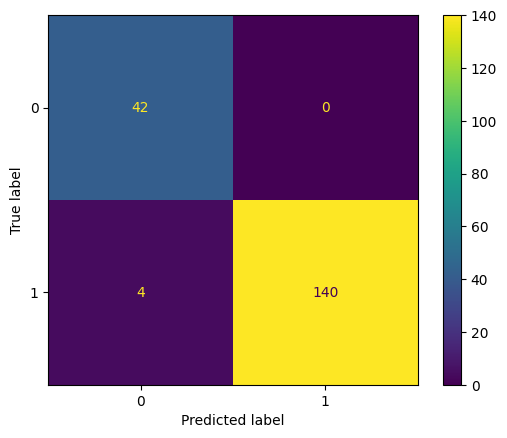

In [52]:
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
print(classification_report(y_valid, y_pred, digits = 6))

In credit card approval prediction, it is crucial to predict correctly the **accuracy score**, which means the machine learning model is able to predict the approval status of the applications as approved that originally got approved, and vice versa.

If the defect in credit card approval prediction can be kept at a very low level, the credit card issuer will not have a problem handling the credit default status.

In [69]:
report_on_valid = classification_report(y_valid, y_pred, output_dict = True)
acc_on_valid = report_on_valid["accuracy"]

print(f"The accuracy score on validation datasets is: {round(acc_on_valid, 6)},\nwhich is considered a high score")

The accuracy score on validation datasets is: 0.978495,
which is considered a high score


## Evaluation

Now let's implicate the testing dataset to evaluate the chosen model's performance.

In [54]:
y_pred_eval = best_model.predict(x_test_base)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        49
           1       1.00      0.98      0.99       173

    accuracy                           0.99       222
   macro avg       0.97      0.99      0.98       222
weighted avg       0.99      0.99      0.99       222



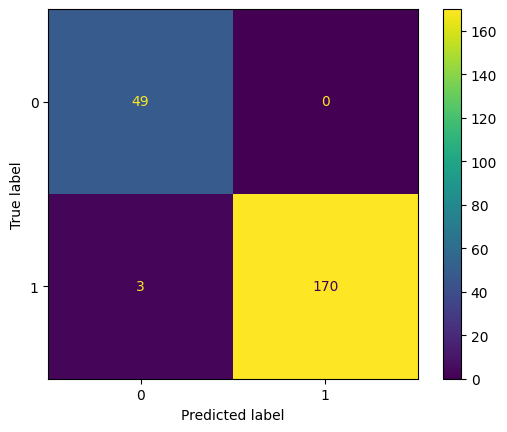

In [55]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_eval)
print(classification_report(y_test, y_pred_eval))

In [70]:
report_on_test = classification_report(y_test, y_pred_eval, output_dict = True, digits = 6)
acc_on_test = report_on_test["accuracy"]

print(f"The accuracy score on testing datasets is: {round(acc_on_test, 6)}")

The accuracy score on testing datasets is: 0.986486


When the model is applied to the testing datasets which contain more data than the validation one, it performs better, the accuracy score improves.